<a href="https://colab.research.google.com/github/MitanshGor/AnalogClock/blob/main/segment_and_augment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Old segmentation technique

Imports for image segmentation using HSV

In [ ]:
import numpy as np 
import cv2
import os
import random
import matplotlib.pyplot as plt

Segmentation using hsv for plant village dataset

Credits: J.D. stackoverflow, https://www.codetd.com/en/article/8155882

In [ ]:
def hsv_mask(image):    
    # create hsv
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # set lower and upper color limits
    low_val = (0,60,0)
    high_val = (179,255,255)
    # Threshold the HSV image 
    mask = cv2.inRange(hsv, low_val,high_val)
    # remove noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=np.ones((8,8),dtype=np.uint8))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    mask = cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernel)
    return mask

def fill_mask(mask):
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    len_contour = len (contours)
    contour_list = []
    for i in range(len_contour):
        drawing = np.zeros_like(mask, np.uint8)  # create a black image
        img_contour = cv2.drawContours(drawing, contours, i, (255, 255, 255), -1)
        contour_list.append(img_contour)

    out = sum(contour_list)
    return out

To get images from the storage

Returns numpy array

In [ ]:
#Returns np array of images and labels
def getImages(getting_plant_class=-1,x=128,y=128,path='newData',n=100):

    #Making empty lists
    imgs=[]
    
    #Getting plant classes from the dataset
    plant_classes=[name for name in os.listdir(path)]
    
    #Getting the requested plant (in getting_plant_class)
    take_classes=[]
    if getting_plant_class==-1:
        #Gets all plants
        take_classes=list(range(len(plant_classes)))
    else:
        #Gets requested plant
        take_classes.append(getting_plant_class)
        
    #For each plant
    for i in range(len(take_classes)):
        
        #Gets disease classes
        disease_classes=[name for name in os.listdir(path+'/'+plant_classes[take_classes[i]])]
        
        #For each disease
        for disease_class in disease_classes:  
            
            #Gets images available for that particular disease
            images=[name for name in os.listdir(path+'/'+plant_classes[take_classes[i]]+'/'+disease_class)]
            
            #Takes random images for batch generation
            
            sample_n=n//(len(take_classes)*len(disease_classes))
            if sample_n>=n:
                sample_n=n-1
            take_imgs=random.sample(range(n), sample_n)
            
            #Adds image and corresponding label to an array
            for img in take_imgs:                
                imgs.append(cv2.resize(cv2.cvtColor(cv2.imread(path+'/'+plant_classes[take_classes[i]]+'/'+disease_class+'/'+images[img]),cv2.COLOR_BGR2RGB),(x,y)))

    #Converts list to np array
    imgs=np.array(imgs,dtype=np.uint8)
    
    return imgs

Sample HSV segmentation; random image everytime, so you might find perfect segmentation but it isn't that way always

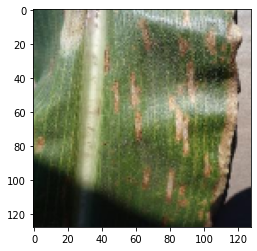

In [ ]:
imgs=getImages()
img=imgs[0]
plt.imshow(img)
plt.show()

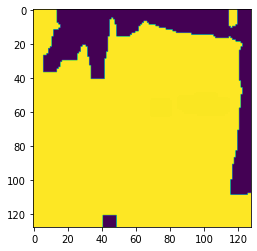

In [ ]:
plt.imshow(fill_mask(hsv_mask(img)))
plt.show()

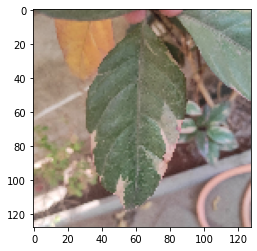

In [ ]:
testimgs=getImages(path='testrt',n=5)[0]
testimg=testimgs[0]
plt.imshow(testimg)
plt.show()

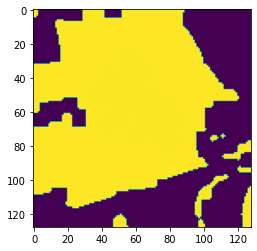

In [ ]:
plt.imshow(fill_mask(hsv_mask(testimg)))
plt.show()

# UI to create mask for training model

Imports for the UI

In [ ]:
import tkinter as tk
from PIL import ImageTk,Image
from os import walk
from scipy import ndimage
import random
import numpy as np 
import cv2

Center zoom using cv2

Credits: Aelius, MohamedEzz from Stackoverflow

In [ ]:
def cv2_clipped_zoom(img, zoom_factor=0):

    """
    Center zoom in/out of the given image and returning an enlarged/shrinked view of 
    the image without changing dimensions
    ------
    Args:
        img : ndarray
            Image array
        zoom_factor : float
            amount of zoom as a ratio [0 to Inf). Default 0.
    ------
    Returns:
        result: ndarray
           numpy ndarray of the same shape of the input img zoomed by the specified factor.          
    """
    if zoom_factor == 0:
        return img


    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)
    
    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int32)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]
    
    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)
    
    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result

Generating window and functions for image manipulation

In [ ]:
win=tk.Tk()
canvas=tk.Label(win)

    
px,py=0,0
imgn=-1
currmask=None
scale=4

#Label to show status
status = tk.StringVar()
statusLabel = tk.Label(win,textvariable= status)

status.set("Left to mask, right to remove")

def setimg(img,mask):    
    nmask=((mask/255)+1)/2 
    nmask=nmask.reshape(nmask.shape[0], nmask.shape[1], 1)
    #Generating image object to show
    
    img = img*nmask
    
    img = Image.fromarray(np.array(img,dtype=np.uint8))  
    img = img.resize((mask.shape[0]*scale, mask.shape[1]*scale), Image.ANTIALIAS)
    imgtk = ImageTk.PhotoImage(image=img)

    
    
    #Setting image to the UI element
    canvas.imgtk = imgtk
    canvas.configure(image=imgtk)

def augment(img,mask,path='BGseg/',rotate=True,zoom=True,bg=True,n=5):
    mask=np.array(mask,dtype=np.float32)
    mask/=255
    mask=np.round(mask)
    mask*=255
    mask=np.array(mask,dtype=np.uint8)
    imgs=[img]
    masks=[mask]
    for i in range(n):
        newimg=np.copy(img)
        newmask=np.copy(mask)
        
        if bg:
            image=[name for name in os.listdir(path)]
            image=image[random.randint(0,len(image)-1)]
            image=cv2_clipped_zoom(ndimage.rotate(cv2.resize(cv2.cvtColor(cv2.imread(path+'/'+image),cv2.COLOR_BGR2RGB),(img.shape[0],img.shape[1])), random.randint(0,360), reshape=False),(random.random()/2)+1)
            
            newimg=cv2.bitwise_and(newimg,newimg, mask=newmask)
            image=cv2.bitwise_and(image,image, mask=255 - newmask)
            
            newimg=cv2.add(newimg,image)
        if rotate:
            rran=random.randint(0,360)
            newimg=ndimage.rotate(newimg, rran, reshape=False)
            newmask=ndimage.rotate(newmask, rran, reshape=False)
        if zoom:
            zran=(random.random()/2)+1
            newimg=cv2_clipped_zoom(newimg,zran)
            newmask=cv2_clipped_zoom(newmask,zran)
        
        imgs.append(newimg)
        masks.append(newmask)
    return imgs,masks
def saveimg(path):
    #getting new id
    gid=0

    filenames=next(walk(path), (None, None, []))[2]
    for i in range(len(filenames)):        
        if filenames[i][:1]=="i":
            gid=max(gid,int(filenames[i][1:filenames[i].index('_')])+1)

    aimgs,amasks=augment(imgs[imgn],currmask)
    #Save with id
    for aid in range(len(aimgs)):
        im = Image.fromarray(aimgs[aid])
        im.save(path+'i'+str(gid)+"_"+str(aid)+".jpeg")
        mask = Image.fromarray(amasks[aid])
        mask.save(path+'m'+str(gid)+"_"+str(aid)+".jpeg")
    
    
def nextimg():
    global currmask,imgn
    if imgn>=0:
        saveimg('Manseg/')
    imgn+=1
    currmask=fill_mask(hsv_mask(img))
    setimg(imgs[imgn],currmask)

nextbtn = tk.Button(win,text = "Next >",command = nextimg)




Setting functions needed for UI interactions

In [ ]:
status_str=''
def showframe():
      
    setimg(imgs[imgn],currmask)    
    canvas.after(1000//30, showframe)
    
    
cursor_size=4

def motion(event):   
    
    global px, py,status_str 
    
    py, px = round((event.x-2)/scale), round((event.y-2)/scale)
    
    status_str="X:"+str(px)+"\tY:"+str(py)  
    status.set(status_str)
    
    fx=max(0,px-cursor_size)
    tx=min(currmask.shape[0],px+cursor_size)
    fy=max(0,py-cursor_size)
    ty=min(currmask.shape[1],py+cursor_size)
    if event.state%33==0:
        currmask[fx:tx,fy:ty]=255
    if event.state%129==0:
        currmask[fx:tx,fy:ty]=0
    

def onKeyPress(event):
    global cursor_size
    if event.char=='w':
        cursor_size+=1
    if event.char=='s' and cursor_size>0:
        cursor_size-=1   

Calling the UI to run

In [ ]:
canvas.bind('<Motion>', motion)
win.bind('<KeyPress>', onKeyPress)

nextimg()
showframe()
canvas.pack()
statusLabel.pack()
nextbtn.pack()
win.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "D:\Software\Programming\Anaconda\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\vedhs\AppData\Local\Temp/ipykernel_3324/1332821543.py", line 90, in nextimg
    setimg(imgs[imgn],currmask)
IndexError: index 99 is out of bounds for axis 0 with size 99
Exception in Tkinter callback
Traceback (most recent call last):
  File "D:\Software\Programming\Anaconda\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "D:\Software\Programming\Anaconda\lib\tkinter\__init__.py", line 814, in callit
    func(*args)
  File "C:\Users\vedhs\AppData\Local\Temp/ipykernel_3324/3001030511.py", line 4, in showframe
    setimg(imgs[imgn],currmask)
IndexError: index 99 is out of bounds for axis 0 with size 99
